# (Optional) Chapter V - Natural Language Processing

This notebook is aimed to work alongside our explanation to help illustrate how to begin the basics of natural language processing. We will mainly focus on the concepts behind it, as the code is relatively simple.

- The basics of Natural language processing
- TF/IDF
- Keyword extraction
- Frequency distributions
- Topic modelling


- Named entity extraction
- Relational data (structuring into networks)

## Section A) Setup

We'll first import our required packages. For the basics of natural language processing we're going to be using nltk. You'll need to install this in your current enviroment using the terminal.

To make sure your enviroment is set up, open your terminal. The line should begin with (base).

- We have previously used 'conda create -n enviroment_name' to create an enviroment. Now use 'conda activate enviroment_name' to open your enviroment, once you've run this the line should start with (enviroment_name).

- Once in the enviroment we can install packages. We want to install them here rather than in the base so that they are only used for this project. 

- To do this use 'conda install package_name'.
In this case 'conda install nltk'.


In [11]:
# conda activate your_enviroment_name
# conda install nltk

In [12]:
# Set up imports
import pandas as pd, matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

import gensim
# from gensim.corpora import Dictionary
import pyLDAvis

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
import string # This provides us a list of punctuation later down the line
import plotly.graph_objects as go
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models, similarities


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ellencharlesworth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's now load in the dataframe and start cleaning. 
Note: this file is tab seperated (see how this changes read_csv below)

In [30]:
df = pd.read_csv('../../data/sample_museum_tweets.tsv', sep='\t')

### A) Data cleaning and Tokenization

Let's check what out data looks like.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  50000 non-null  int64  
 1   ts                  50000 non-null  object 
 2   museum_account      50000 non-null  object 
 3   original_text       50000 non-null  object 
 4   is_retweet          50000 non-null  bool   
 5   is_reply            50000 non-null  bool   
 6   interactions_count  50000 non-null  float64
dtypes: bool(2), float64(1), int64(1), object(3)
memory usage: 2.0+ MB


In [31]:
df.head(10)

,id,ts,museum_account,original_text,is_retweet,is_reply,interactions_count
0,5798944681378,2021-07-22 19:38:34+00:00,ancienthousemus,"@AncientHouseMus @artukdotorg Ugh, no wonder h...",False,True,0.0
1,8702741370361,2019-01-02 08:25:06+00:00,livcathedral,Looking for a fun challenge to take as a famil...,False,False,4.0
2,4436751452541,2020-04-06 10:07:47+00:00,samuseums,@samuseums A great choice to show the beautifu...,False,True,2.0
3,7789471450859,2019-06-29 07:42:00+00:00,hull_museums,Our Hands on History Museum is open today 12no...,False,True,1.0
4,1508119645064,2022-05-18 11:12:56+00:00,ecmfcm,@CynthiaTheBaker @BarnsleyMuseums @SMTrust @Da...,False,True,1.0
5,3249899610136,2019-11-09 11:56:24+00:00,bm_ag,"Yes it is a miserable weather day, but we've g...",False,False,14.0
6,3071854785518,2022-02-10 10:56:10+00:00,seacitymuseum,"RT @SotonStories: ""...Nobody said LGBTQ+ in th...",True,False,1.0
7,5846312467152,2020-09-11 22:35:33+00:00,trinityhouse_uk,Our support vessels play a huge part in the #V...,False,True,49.0
8,6250125091251,2019-05-13 22:05:58+00:00,largsmuseum,RT @Scotmaritime: Our FREE Powering Up! Scienc...,True,False,9.0
9,6455006045973,2022-02-21 09:12:40+00:00,wabbey,@wabbey 💜🙏💜 https://t.co/tlTHjZOTBf,False,True,1.0


✏️ [Ex. 1]

Let's clean up the datatypes first.
- Rename 'original_text' to 'text'
- Make sure that the column's datatype is a string
- How many null values are there in 'text'?

The dataset we have has already been cleaned so there is not much to do! But you may want to be wary of duplicates in your own dataset. The pandas function drop_duplicates() will help. You can check the length of the df before and after to see how many it found. Check the documentation for more details.

In [32]:
df = df.rename(columns={'original_text':'text'})
df['text'] = df['text'].astype(str)

# # Note it's always useful, just in case they're saved as a string 'NaN'.
# df['text'].value_counts()

To make our dataset more homogenous, for now we will focus on all of the tweets that are not replies. This is becuase replies tend to have different characteristics (shorter, more boring vocabulary) so we'll drop them for this exercise. 

Here we can use loc, or simply a tilda (~) for 'not'.

When we do this we drop more than half the tweets. 

In [17]:
print(len(df))
df = df[~df["is_reply"]]
print(len(df))


50000
23622


## Section B) Preprocessing Tweets
https://towardsdatascience.com/lda-topic-modeling-with-tweets-deff37c0e131

https://medium.com/swlh/quick-text-pre-processing-c444f0ed9dcc

Here we will: 
- Remove URLs (you could also remove mentions using what we learnt yesterday or the code below, but we will leave them for now)
- Remove stop words, punctuation, and lowercase all words
- Tokenize each tweet
- Remove any remaining special characters
- Lemmatize/Stem the tweets

To remove urls, we will need to use regex with string operators. Here are some helpful guides:
https://blog.hpc.qmul.ac.uk/Beginners-Guide-to-Regular-Expressions/

And for a more full description: https://regexone.com/

You can test your regex with this site: 
https://regex101.com/ 

In [18]:
def remove_urls(df, text_column_name):
    df[text_column_name] = df[text_column_name].str.replace(r"http\S+", "", regex=True)
    return (df)

df = remove_urls(df, 'text')
df.head()

,id,ts,museum_account,text,is_retweet,is_reply,interactions_count
1,8702741370361,2019-01-02 08:25:06+00:00,livcathedral,Looking for a fun challenge to take as a famil...,False,False,4.0
5,3249899610136,2019-11-09 11:56:24+00:00,bm_ag,"Yes it is a miserable weather day, but we've g...",False,False,14.0
6,3071854785518,2022-02-10 10:56:10+00:00,seacitymuseum,"RT @SotonStories: ""...Nobody said LGBTQ+ in th...",True,False,1.0
8,6250125091251,2019-05-13 22:05:58+00:00,largsmuseum,RT @Scotmaritime: Our FREE Powering Up! Scienc...,True,False,9.0
11,3284713454042,2020-01-04 14:16:54+00:00,tateliverpool,RT @its_jess13: Definitely recommend a visit t...,True,False,3.0


### Removing stopwords and tokenization

In [19]:
# Implement stopwords
stop_words = stopwords.words('english')

# Add punctuation to our stopwords list
stop_words += list(string.punctuation) # This comes from python itself and is a full list of non-alphabetical characters. e.g. -./:;<=>?@

# Add integers
stop_words += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [33]:
tokenize_and_lowercase('fkdsj kjsdfh khfsd fdj')

['fkdsj', 'kjsdfh', 'khfsd']

In [35]:
def tokenize_and_lowercase_new(text):
    tokens = word_tokenize(text)

    short_removed = []
    for token in tokens:
        token_lower = token.lower()
        if (token_lower not in stop_words)&(len(token_lower)>3):
            short_removed.append(token_lower)
    return short_removed


# temp_dw['tweet_text'] = temp_dw['tweet_text'].apply(tokenize_lowercase)
# temp_dw['tweet_text'].head(10)
df['text_tokens'] = df['text'].apply(tokenize_and_lowercase_new)

df.text_tokens.head(20)

0     [ancienthousemus, artukdotorg, wonder, gave, a...
1     [looking, challenge, take, family, year, helpi...
2     [samuseums, great, choice, show, beautiful, se...
3     [hands, history, museum, open, today, 12noon-4...
4     [cynthiathebaker, barnsleymuseums, smtrust, da...
5     [miserable, weather, something, cheer, come, a...
6     [sotonstories, nobody, said, lgbtq+, days, sce...
7     [support, vessels, play, huge, part, visitingc...
8     [scotmaritime, free, powering, science, festiv...
9                    [wabbey, https, //t.co/tlthjzotbf]
10    [carshaltonviews, thank, involved, putting, to...
11    [its_jess13, definitely, recommend, visit, the...
12    [marina_white, riverside, picnic, reached, who...
13    [steveaprocter, t86_dan, richard99366022, clar...
14    [milestoneshct, spitfire, back, meet, book, sl...
15    [heard, displaying, entrants, year, european, ...
16    [autographabp, autograph, touring, exhibition,...
17    [fitzmuseum_uk, themerl, charming, kind, t

Great! Each row is now a list of words that were in that tweet. However, it's a little bit cleaner than the method we used before, as we now don't have any punctuation or common words such as 'a' or 'the'. This is a much better start for analysis. 

There is one last step, we still need to lemmatize or perform stemming. Lemmatizing is a little bit more sophisticated (remember our example of leaf and leaves) so we will lemmatize using nltk. 

In [36]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_text(df_text):
    lemmatized_words =[]
    for w in df_text:
        lemmatized_words.append(lemmatizer.lemmatize(w))
    return lemmatized_words

df['text_lemmatized'] = df['text_tokens'].apply(lemmatize_text)
df['text_lemmatized'].head()

0    [ancienthousemus, artukdotorg, wonder, gave, a...
1    [looking, challenge, take, family, year, helpi...
2    [samuseums, great, choice, show, beautiful, se...
3    [hand, history, museum, open, today, 12noon-4p...
4    [cynthiathebaker, barnsleymuseums, smtrust, da...
Name: text_lemmatized, dtype: object

In [ ]:
# You may want to save the dataframe for ease of access later.
df.to_pickle("../../data/lemmatized_museum_tweets.pkl")  

# to read it back to a dataframe we would use: 
# df = pd.read_pickle("../../data/lemmatized_museum_tweets.pkl") 

https://www.youtube.com/watch?v=UkmIljRIG_M&t=179s
For evalutation of topic models

## Section C) Basic Analysis

In [ ]:
df = pd.read_pickle("../../data/lemmatized_museum_tweets.pkl") 

We saw how to visualise the length of museum tweets yesterday, but using nltk, we can do additional checks on the most common words and how they change over time.

In [37]:
from nltk.probability import FreqDist

#iterate through each tweet, then each token in each tweet, and store in one list
#flat_words = [item for sublist in df['text'] for item in sublist]

flat_words = []
for sublist in df['text_lemmatized']:
    for item in sublist:
        flat_words.append(item)

word_freq = FreqDist(flat_words)
word_freq.most_common(30)

[('http', 32405),
 ('museum', 3353),
 ('today', 2993),
 ('year', 2456),
 ('time', 2195),
 ('great', 2156),
 ('visit', 1981),
 ('book', 1981),
 ('exhibition', 1895),
 ('thank', 1828),
 ('open', 1777),
 ('like', 1772),
 ('find', 1760),
 ('week', 1742),
 ('look', 1708),
 ('work', 1688),
 ('thanks', 1574),
 ('join', 1528),
 ('ticket', 1489),
 ('collection', 1469),
 ('love', 1465),
 ('free', 1433),
 ('first', 1430),
 ('looking', 1407),
 ('would', 1397),
 ('back', 1396),
 ('please', 1339),
 ('know', 1300),
 ('part', 1283),
 ('event', 1252)]

In [38]:
# It is currently a list of tuples, but we can easily convert it into a dictionary, which we could turn into a wordcloud.
top_30_words = dict(word_freq.most_common(30))
top_30_words

{'http': 32405,
 'museum': 3353,
 'today': 2993,
 'year': 2456,
 'time': 2195,
 'great': 2156,
 'visit': 1981,
 'book': 1981,
 'exhibition': 1895,
 'thank': 1828,
 'open': 1777,
 'like': 1772,
 'find': 1760,
 'week': 1742,
 'look': 1708,
 'work': 1688,
 'thanks': 1574,
 'join': 1528,
 'ticket': 1489,
 'collection': 1469,
 'love': 1465,
 'free': 1433,
 'first': 1430,
 'looking': 1407,
 'would': 1397,
 'back': 1396,
 'please': 1339,
 'know': 1300,
 'part': 1283,
 'event': 1252}

In [40]:
raf_museums_tweets = df.loc[df['museum_account']=='rafmuseum']
horniman_tweets = df.loc[df['museum_account']=='hornimanmuseum']

#flat_words_raf = [item for sublist in raf_museums_tweets['text'] for item in sublist]
flat_words_raf = []
for sublist in raf_museums_tweets['text_lemmatized']:
    for item in sublist:
        flat_words_raf.append(item)

word_freq_raf = FreqDist(flat_words_raf)
top_10_words_raf = dict(word_freq_raf.most_common(10))
top_10_words_raf

{'http': 465,
 'rafmuseum': 131,
 'london': 66,
 'museum': 64,
 'cosford': 54,
 'aircraft': 43,
 'free': 42,
 'year': 31,
 'story': 30,
 'detail': 28}

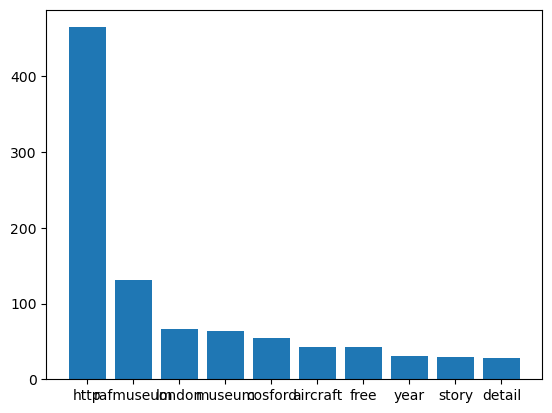

In [41]:
import matplotlib.pyplot as plt

plt.bar(range(len(top_10_words_raf)), list(top_10_words_raf.values()), align='center')
plt.xticks(range(len(top_10_words_raf)), list(top_10_words_raf.keys()))

plt.show()


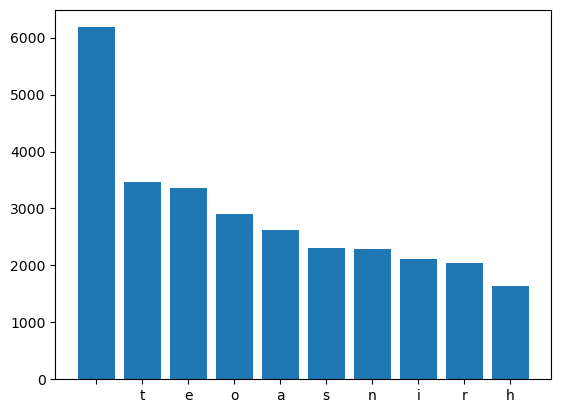

In [42]:
flat_words_horn = [item for sublist in horniman_tweets['text'] for item in sublist]
word_freq_horn = FreqDist(flat_words_horn)
top_10_words_horn = dict(word_freq_horn.most_common(10))

plt.bar(range(len(top_10_words_horn)), list(top_10_words_horn.values()), align='center')
plt.xticks(range(len(top_10_words_horn)), list(top_10_words_horn.keys()))

plt.show()

## Section D) Topic modeling

So what is our data about? One interesting thing we can try is topic modeling.

In [44]:
# First we have to create a bag of words

#create dictionary
text_dict = gensim.corpora.Dictionary(df['text_lemmatized'])

#view integer mappings
text_dict.token2id

tweets_bow = []
for tweet in df['text_lemmatized']:
    tweets_bow.append(text_dict.doc2bow(tweet))

In [53]:
all_words = []
for tokens in df['text_lemmatized']:
    for word in tokens:
        all_words.append(word)


tweet_length_in_lemmas = []
for tokens in df['text_lemmatized']:
    tweet_length_in_lemmas.append(len(tokens))

tweet_length_in_lemmas = [len(tokens) ]
vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_length_in_lemmas)))

659020 words total, with a vocabulary size of 120866
Max tweet length is 28


In [51]:
from gensim.models.ldamodel import LdaModel

# When we train a model there are a number of parameters that we can add.
# k here represents the number of topics
k = 7
tweets_lda = LdaModel(tweets_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)

tweets_lda.show_topics()
# tweets_lda.save("../../data/lda_museum_tweets_7.model") 
tweets_lda.save("lda_museum_tweets_7.model") 

# https://stackoverflow.com/questions/17354417/gensim-how-to-save-lda-models-produced-topics-to-a-readable-format-csv-txt-et

KeyboardInterrupt: 

In [ ]:
pyLDAvis.enable_notebook()
lda_viz = pyLDAvis.gensim_models.prepare(tweets_lda, tweets_bow, dictionary=tweets_lda.id2word)
pyLDAvis.show(lda_viz, local=False)
lda_viz

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [07/Aug/2025 10:36:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Aug/2025 10:36:53] code 404, message Not Found
127.0.0.1 - - [07/Aug/2025 10:36:53] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.286413  0.031060       1        1  32.623239
6      0.269041  0.039393       2        1  31.039823
5     -0.015033 -0.274141       3        1   9.957817
4     -0.069937  0.089689       4        1   8.908366
0     -0.143442  0.060308       5        1   6.536850
3     -0.159275  0.037154       6        1   5.553748
1     -0.167767  0.016536       7        1   5.380157, topic_info=          Term         Freq        Total Category  logprob  loglift
83        book  1284.000000  1284.000000  Default  30.0000  30.0000
145       join  1147.000000  1147.000000  Default  29.0000  29.0000
136     ticket   950.000000   950.000000  Default  28.0000  28.0000
30        free   970.000000   970.000000  Default  27.0000  27.0000
29       event   806.000000   806.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
5551      cold    40.382334    56.604581   Topic7  -6.0782   2.5848
1935     roman    68.589568   166.769637   Topic7  -5.5484   2.0340
902       mind    32.759038    43.110470   Topic7  -6.2874   2.6479
940    britain    31.053876   136.351664   Topic7  -6.3408   1.4429
7661  watching    27.438264    44.920827   Topic7  -6.4646   2.4295

[383 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1654      1  0.990292   10am
1654      3  0.006877   10am
1691      1  0.996176   11am
5940      5  0.992947   12th
946       3  0.988261   21st
...     ...       ...    ...
18        1  0.419826   year
18        2  0.519987   year
18        3  0.008524   year
18        4  0.051146   year
535       5  0.973765  youth

[562 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 6, 5, 1, 4, 2])

In [ ]:
#Creating a bag of words
from gensim.corpora import Dictionary

#create dictionary
text_dict = Dictionary(df.text)

#view integer mappings
text_dict.token2id

tweets_bow = [text_dict.doc2bow(tweet) for tweet in df['text']]

In [ ]:
from gensim.models.ldamodel import LdaModel

# k here represents the number of topics.
k = 7
tweets_lda = LdaModel(tweets_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)

tweets_lda.show_topics()
tweets_lda.save('lda_museum_tweets_7.model')
# https://stackoverflow.com/questions/17354417/gensim-how-to-save-lda-models-produced-topics-to-a-readable-format-csv-txt-et

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(tweets_lda, tweets_bow, dictionary=tweets_lda.id2word)
pyLDAvis.show(lda_viz)
lda_viz

FileNotFoundError: [Errno 2] No such file or directory: 'https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.4.0/pyLDAvis/js/ldavis.v1.0.0.css'

## Section E) 

Looking at how word use changes over time.

In [ ]:
# Ask for user input

# user_input = input("Would words would you like to chart over time (seperate with commas)? ").lower()
# user_input = [x.strip() for x in user_input.split(',')]
# list_of_words = pd.DataFrame(user_input, columns=['words'])

# or type them myself! 

list_of_words = ["lockdown","home","corona","covid-19","covid","coronavirus"]
word_df = pd.DataFrame(list_of_words, columns=['words'])

In [ ]:
# Tokenise and lematize our words using our previous functions

word_df['words'] = word_df['words'].apply(tokenize_and_lowercase)
word_df['words'] = word_df['words'].apply(lemmatize_text)

mylist = word_df['words'].to_list()
mylist = [x[0] for x in mylist]

In [ ]:
newdf = df #.head(3000000)
newdf['len_intersect'] = newdf.text.apply(lambda x: len(list(set(x) & set(mylist))))
newdf['intersection'] = newdf.text.apply(lambda x: ','.join(list(set(x) & set(mylist))))
#df1 = df.loc[df['mask']==True] #not sure it is indexed correctly

In [ ]:
new_df = newdf.copy()

In [ ]:
new_df['ts'] = pd.to_datetime(new_df['ts'], errors='coerce')
new_df['id'] = new_df.index
new_df = new_df.sort_values(by='ts')
new_df.dropna(inplace = True)

# new_df['truncate_date'] = new_df['ts'].dt.floor('d')
# print(new_df['truncate_date'])


## Further resources (natural language processing and beyond...)

This has been a brief introduction to some basic nlp tasks, but it only scratches the surface. The below links point you in the direction of some helpful resources. They represent a wide range of approaches including neural networks, so do keep in mind what we talked about regarding black box models!

### 1) spaCy
For further exploration of syntax and named entity recognition, you can explore the spaCy library. They have visualisers to help you get to grips with what it does.
https://demos.explosion.ai/displacy-ent
https://demos.explosion.ai/displacy

I would encourage you to explore the different examples used in the "Guides" section of the spaCy documentation.
https://spacy.io/usage/linguistic-features
https://spacy.io/usage/rule-based-matching

It might be helpful for some of your projects!

### 2) berTopic
Often the go-to tool these days for neural topic modeling. There is a very helpful quickstart guide!
https://maartengr.github.io/BERTopic/index.html

### 3) Transkribus
For those of you who have not processed your scans of text yet and need to do OCR (Optical Character Recognition), Transkribus is to go-to tool for transcribing texts (free for a while, then talk to your university/send them an email). It's a great team and run by academics for academics. Takes some work to figure out all of the functions and interface but it well worth investing the time!

Different models be used to work with either handwritten texts or printed/typed, as well as for a wide selection of languages and time periods. 
https://www.transkribus.org/

### 4) Hugging face
Most of the libraries mentioned here have a number of pretrained models avaialble (at different sizes), for everything else, there's hugging face.
https://huggingface.co/

It's not ideal in many ways, but it is the largest repository of pretrained models and datasets currently out there, have an explore! It will be especially helpful for those of you not working in English.
An alternative would be kaggle (more for datasets). 

### 5) Distant viewing lab
Fantastic resource for computer vision (step by step guide)
https://distantviewing.org/

But they also have a section on sentiment analysis using neural networks.
https://distantviewing.org/dvscripts/sentiment.html

### 6) GLAM workbench 
A series of amazing notebooks exploring GLAM data. 
https://glam-workbench.net/

I've added some helpful links based on some of your projects! However, feel free to have an explore of the whole site, there are many more notebooks you may find useful. 

Here they have a guide on how to run these notebooks:

https://glam-workbench.net/trove-newspapers/#data-and-images

#### Useful notebooks that have direct relevance to some of your projects include: 
Finding nouns, verbs, sentences, and cleaning your text:
https://glam-workbench.net/trove-books/recipe-generator/

Geomapping:
https://glam-workbench.net/trove-newspapers/Map-newspaper-results-by-place-of-publication/ OR 
https://glam-workbench.net/trove-newspapers/Map-newspaper-results-by-place-of-publication-over-time/

Topic modeling of parlimentary press releases: 
https://glam-workbench.net/trove-journals/topic-modelling-parliament-press-releases/?h=topic

Topic modeling of books:
https://glam-workbench.net/trove-books/exploring-digitised-books-adel-rahmani/?h=topic

(Alas, should be noted that the trove notebooks aren't being updated due to issues with the National Library of Australia being weird about their API's terms and conditions, but you can still take and adapt them for yourself!)

### 7) Plotly
Not nlp related but is a different and really nice plotly library where the visualisations are interactive. Worth an experiment: 
https://plotly.com/python/

## Lastly if you come across any great resources yourself feel free to share! 